# Interconnect Final Project

The telecom operator Interconnect would like to be able to forecast their churn of clients. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts, to predict whether a customer will leave. Ensure AUC-ROC metric is 85 > and high accuracy.

## Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

# Data Preprocessing

In [1]:
# core imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model and metric requirements
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score 

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

## Initial Check

In [2]:
contract = pd.read_csv('C:/Users/Kayo/Downloads/final_provider/final_provider/contract.csv')
internet = pd.read_csv('C:/Users/Kayo/Downloads/final_provider/final_provider/internet.csv')
personal = pd.read_csv('C:/Users/Kayo/Downloads/final_provider/final_provider/personal.csv')
phone = pd.read_csv('C:/Users/Kayo/Downloads/final_provider/final_provider/phone.csv')

In [3]:
# Checking Dataframe info, our target is 'No' in contract EndDate
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Paperless billing in contract seems like a useless column, though it could be an indicator of age would might be helpful for our predictions. Additionally, there's little reason to keep these separate, we can merge these into one dataframe on customerID. Many of these columns can also be converted to 0s or 1s.

## Processing

In [7]:
# Creating a column so our model can better understand missing values for the phoneline df
phone['has_phoneline'] = 'Yes'

# Dataframe merging
df = reduce(lambda left, right: pd.merge(left, right, on=['customerID'], how='outer'), [contract, internet, personal, phone])

# Replacing NaN from merger
df['has_phoneline'] = df['has_phoneline'].fillna('None')
df['MultipleLines'] = df['MultipleLines'].fillna('No')

Successfully merged our datasets into one, now making it easier to use.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [9]:
# Changing strings into int
df_exclude = df[['BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'customerID']]
df_mod = pd.get_dummies(df[['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'has_phoneline']], drop_first=True)
df = df_exclude.merge(df_mod, left_index=True, right_index=True)

# Converting columns to lowercase
df.columns = df.columns.str.lower()

In [10]:
# Converting target into new column
target_list = []
for row in df['enddate']:
    target_list.append(row != 'No')

df['target'] = pd.get_dummies(target_list, drop_first=True)

# Converting old target columns into datetime
df.loc[df['enddate'] == 'No', 'enddate'] = np.NaN

In [11]:
# Removing datetime and the few leftover NaNs from our dataset, to avoid errors
df_final = df.drop(['enddate', 'begindate'], axis=1).dropna()

# CustomerID is no longer needed, but can be used as an index
df_final = df_final.set_index('customerid')

The datetime column will cause an error when making my models, so I instead dropped it here.

In [12]:
# Removing blank cells
df_final['totalcharges'] = pd.to_numeric(df_final['totalcharges'], errors='coerce')
df_final = df_final.dropna()
df_final.reset_index(drop=True, inplace=True)

In [13]:
# Checking for NaN/Duplicates
print('Total NaN Count:', len(df_final) - len(df_final.isnull()))
print('Total Duplicate Rows Count:', len(df_final) - len(df_final.drop_duplicates()))

Total NaN Count: 0
Total Duplicate Rows Count: 22


While ideally I would replace the total charges blank cells with a value similar to monthly charge * months since begindate, the total charges column isn't consistent and thus it would only skew the data.

In [14]:
# Confirming values are fixed
df_final.head()

,monthlycharges,totalcharges,seniorcitizen,type_one year,type_two year,paperlessbilling_yes,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check,internetservice_fiber optic,...,deviceprotection_yes,techsupport_yes,streamingtv_yes,streamingmovies_yes,gender_male,partner_yes,dependents_yes,multiplelines_yes,has_phoneline_yes,target
0,29.85,29.85,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,56.95,1889.50,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,53.85,108.15,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
3,42.30,1840.75,0,1,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,70.70,151.65,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1


In [15]:
# Confirming values are fixed
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         7032 non-null   float64
 1   totalcharges                           7032 non-null   float64
 2   seniorcitizen                          7032 non-null   int64  
 3   type_one year                          7032 non-null   uint8  
 4   type_two year                          7032 non-null   uint8  
 5   paperlessbilling_yes                   7032 non-null   uint8  
 6   paymentmethod_credit card (automatic)  7032 non-null   uint8  
 7   paymentmethod_electronic check         7032 non-null   uint8  
 8   paymentmethod_mailed check             7032 non-null   uint8  
 9   internetservice_fiber optic            7032 non-null   uint8  
 10  onlinesecurity_yes                     7032 non-null   uint8  
 11  onli

# Explore the Data

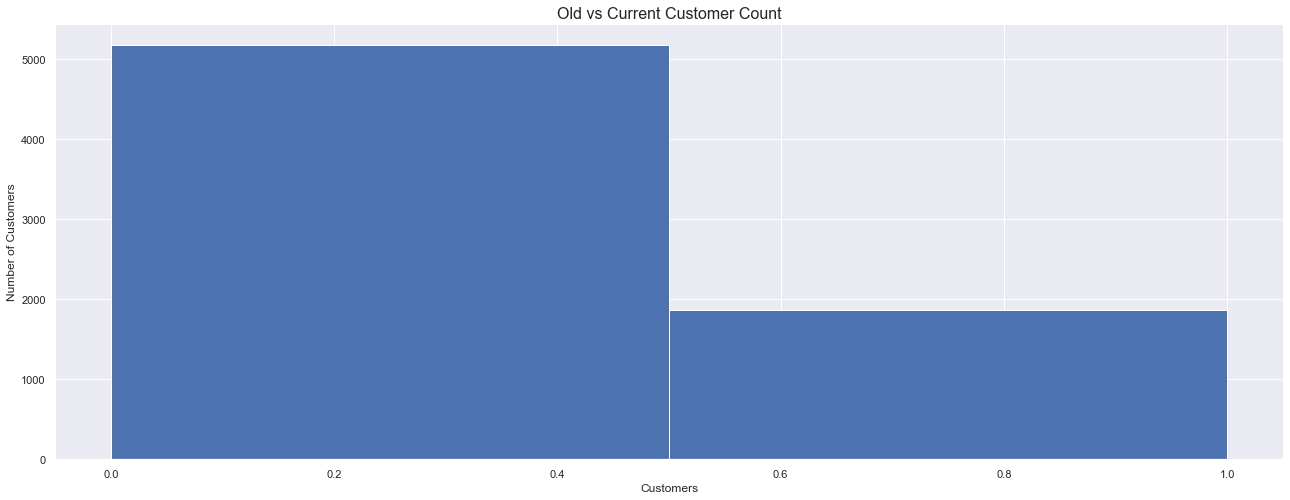

In [16]:
# Showing customer count and how many have left in our dataset
sns.set(rc={'figure.figsize':(22, 8)});
df['target'].plot(kind='hist', bins=2)

plt.ylabel('Number of Customers');
plt.xlabel('Customers');
plt.title('Old vs Current Customer Count', fontsize=16);

Notably, there are about 2.5x more customers still with Interconnect than those who left, showing strong customer retention.

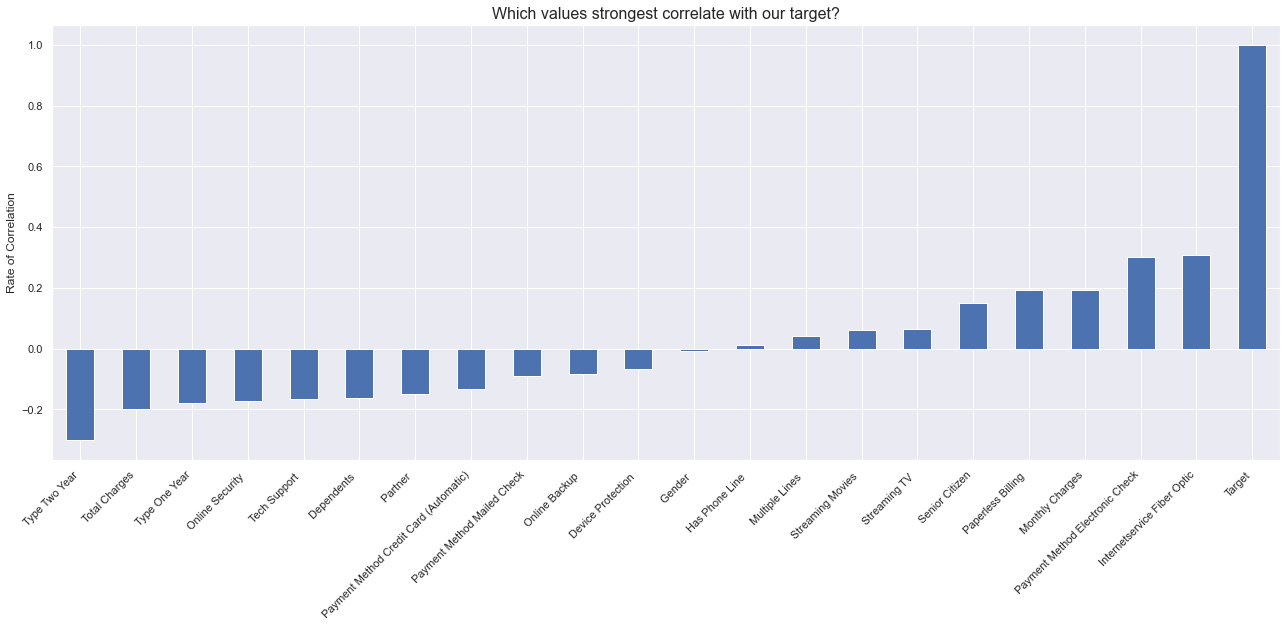

In [17]:
# Plotting correlation and editing column names for better viewability
graph = df_final.rename(
    columns=lambda name: name.replace('_', ' ').replace('yes', '').replace('male', '').replace('no', '').replace('paymentmethod', 'payment method').replace('monthlycharges', 
    'monthly charges').replace('paperlessbilling', 'paperless billing').replace('seniorcitizen', 'senior citizen').replace('streamingmovies', 'streaming movies').replace('multiplelines',
    'multiple lines').replace('deviceprotection', 'device protection').replace('onlinebackup', 'online backup').replace('techsupport', 'tech support').replace('onlinesecurity', 
    'online security').replace('phoneline', 'phone line').replace('totalcharges', 'total charges').title().replace('Streamingtv', 'Streaming TV')).corr()['Target'].sort_values(
    ).plot(kind='bar', figsize=(22, 8));
graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Which values strongest correlate with our target?', fontsize=16);
plt.ylabel('Rate of Correlation');
plt.show()

As we can see by our graph, those that select the two year plan and have the highest amount of charges are less likely to leave, which would make logical sense since someone with Interconnect longer would be more likely to stay.

# Model Creation

In [18]:
# Building our training and test data sets
features_train, features_test, target_train, target_test = train_test_split(
    df_final.drop('target', axis=1), df_final['target'], train_size=0.9, random_state=12345)

print('Training set shapes:', features_train.shape, target_train.shape)
print('Testing set shapes:', features_test.shape, target_test.shape)

Training set shapes: (6328, 21) (6328,)
Testing set shapes: (704, 21) (704,)


In [19]:
# Creating a list of our best model scores
best_accuracy = []
best_roc = []

## Random Forest Classification

In [ ]:
# Tuning Random Forest Regressors parameters using GridSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(3, 15, num = 5)],
}

rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid, cv=4, scoring='roc_auc')
rfc.fit(features_train, target_train)

best_accuracy.append(cross_val_score(rfc, features_train, target_train, scoring='accuracy').mean())
best_roc.append(cross_val_score(rfc, features_train, target_train, scoring='roc_auc').mean())

## Decision Tree Classification

In [ ]:
# Tuning Decision Tree Classification parameters using GridSearchCV
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(3, 15, num = 5)],
    'criterion' : ['gini', 'entropy']
}

dtc = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), param_grid=param_grid, cv=4)
dtc.fit(features_train, target_train)

best_accuracy.append(cross_val_score(dtc, features_train, target_train, scoring='accuracy').mean())
best_roc.append(cross_val_score(dtc, features_train, target_train, scoring='roc_auc').mean())

## Cat Boost Classification

In [ ]:
# Tuning Cat Boost Regressors parameters using GridSearchCV
param_grid = {
    'n_estimators': [1000],
    'depth': [6, 8, 10],
    'learning_rate': [0.001, 0.003]
}

cat = GridSearchCV(estimator=CatBoostClassifier(random_state=123, logging_level='Silent', eval_metric='AUC', loss_function='Logloss'), param_grid=param_grid, cv=4)
cat.fit(features_train, target_train)

best_accuracy.append(cross_val_score(cat, features_train, target_train, scoring='accuracy').mean())
best_roc.append(cross_val_score(cat, features_train, target_train, scoring='roc_auc').mean())

## Best Scores

In [ ]:
# Sanity check our model accuracy
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)

print('Dummy AUC-ROC Score:', roc_auc_score(target_test, dummy_model.predict_proba(features_test)[:, 1]))
print('Dummy Accuracy Score:', accuracy_score(target_test, dummy_predict))

In [ ]:
# Adding model type to list, then merging
model_name = ['Random Forest Classification', 'Decision Tree Classification', 'Cat Boost Classification']
scores = {'Model Name': pd.Series(model_name), 'AUC-ROC Score': pd.Series(best_roc), 'Accuracy Score': pd.Series(best_accuracy)}
  
pd.concat(scores, axis = 1).sort_values('AUC-ROC Score', ascending=False)

In [ ]:
# Final with test set
print('Cat Boost Score with Test Set:', roc_auc_score(target_test, cat.predict_proba(features_test)[:, 1]))

# Conclusion

The winning model is Cat Boost Classifier,
The best hyperparameters are: {'depth': 6, 'learning_rate': 0.003, 'n_estimators': 1000}

The best ROC-AUC score is 0.855 which was around the same score as Random Forest Classification. The train set has noticable improvements in score but is small enough that it can be determined there was little overfitting.

The most important features that affected client leave rates were the fiber optic internet service and monthly charges, which could hint at worse-than-average fiber optic internet and higher costs than market average.